# 📘 Forecasting Migration Flows - Feature Engineering and Modeling

**Author:** _Golib Sanaev_  
**Date:** _2025-09-23_  
**Last Updated:** _2025-10-09_  
**Project:** Forecasting Migration Flows with Machine Learning  

---

### 🎯 **Purpose**

Build a first, time-aware baseline for forecasting **net migration per 1,000 people** using country-level indicators. We engineer features (including a **crisis flag lag** and an **urbanization ratio**), avoid target leakage, and compare **Linear Regression** vs **Random Forest** on a **temporal holdout** (train ≤ 2018, validate 2019–2023).

---

### 📑 **Table of Contents**

1. [Setup and Load Clean Data](#1-setup-and-load-clean-data)  
2. [Target and Feature Engineering](#2-target-and-feature-engineering)  
3. [Time-Aware Train/Validation Split](#3-time-aware-train-validation-split)  
4. [Baselines and Scaling](#4-baselines-and-scaling)  
5. [Models: Linear Regression and Random Forest](#5-models-linear-regression-and-random-forest)  
6. [Evaluation](#6-evaluation)  
7. [Feature Importance (RF, exploratory)](#7-feature-importance-RF-exploratory)  
8. [Error Slices (by Region/Income)](#8-error-slices-by-region-income)  
9. [Save Artifacts](#9-save-artifacts)  
10. [Next Steps](#10-next-steps)  


## 1. Setup and Load Clean Data

In [1]:
# Setup and Load Clean Data

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from IPython.display import display_html

import joblib
import os

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.facecolor": "white", "axes.facecolor": "white"})

DATA_DIR = Path("../data/processed")
df_country = pd.read_csv(DATA_DIR / "countries_clean.csv")

print("Countries dataset:", df_country.shape)
df_country.head()

Countries dataset: (5712, 21)


,Country Name,Country Code,year,pop_density,mobile_subs,exports_gdp,imports_gdp,gdp_growth,gdp_per_capita,under5_mortality,...,net_migration,adol_fertility,life_expectancy,fertility_rate,pop_growth,population,urban_pop_growth,hdi,Region,IncomeGroup
0,Afghanistan,AFG,1990,18.468424,0.0,16.852788,50.731877,2.685773,417.647283,180.7,...,-458737.0,139.376,45.118,7.576,1.434588,12045660.0,1.855712,0.285,Middle East & North Africa,Low income
1,Afghanistan,AFG,1991,18.764667,0.0,16.852788,50.731877,2.685773,417.647283,174.4,...,32782.0,145.383,45.521,7.631,1.591326,12238879.0,2.010729,0.291,Middle East & North Africa,Low income
2,Afghanistan,AFG,1992,20.359343,0.0,16.852788,50.731877,2.685773,417.647283,168.5,...,1197329.0,147.499,46.569,7.703,8.156419,13278974.0,8.574058,0.301,Middle East & North Africa,Low income
3,Afghanistan,AFG,1993,22.910893,0.0,16.852788,50.731877,2.685773,417.647283,163.0,...,1149684.0,149.461,51.021,7.761,11.807259,14943172.0,12.223160,0.311,Middle East & North Africa,Low income
4,Afghanistan,AFG,1994,24.915741,0.0,16.852788,50.731877,2.685773,417.647283,157.7,...,315206.0,156.835,50.969,7.767,8.388730,16250794.0,8.807544,0.305,Middle East & North Africa,Low income


## 2. Target and Feature Engineering

**Design choices:**

- **Target:** `net_migration_per_1000` (not capped).
- Add **crisis flag** (|`net_migration_per_1000`| > 50) and **lag(1)**.
- Engineer `urbanization_rate` = `urban_pop_growth` / `pop_growth` with clipping to reduce instability.
- Add **interaction:** `gdp_growth_x_urban` = `gdp_growth` * `urbanization_rate_stable`.
- Do not use `pop_growth` or `urban_pop_growth` themselves as predictors.
- One-hot encode `Region` and `IncomeGroup` if present; otherwise skip gracefully.
- Strict leakage guard: no migration variables in features.

In [2]:
# Target and Feature Engineering

df = df_country.copy()

# Ensure target exists (safety)
if "net_migration_per_1000" not in df.columns:
    df["net_migration_per_1000"] = (df["net_migration"] / df["population"]) * 1000

# Crisis flag and lag(1)
CAP = 50
df["is_crisis"] = (df["net_migration_per_1000"].abs() > CAP).astype(int)
df = df.sort_values(["Country Name", "year"]).reset_index(drop=True)
df["is_crisis_lag1"] = df.groupby("Country Name")["is_crisis"].shift(1).fillna(0).astype(int)

# Urbanization ratio (stable)
# Handle division, extreme ratios, and residual NaNs
eps = 1e-9
ratio = df["urban_pop_growth"] / df["pop_growth"].replace(0, np.nan)
ratio = ratio.replace([np.inf, -np.inf], np.nan)

# Clip extreme ratios to reduce leverage of noisy small denominators
df["urbanization_rate_stable"] = ratio.clip(lower=-5, upper=5).fillna(1.0)

# Interaction
df["gdp_growth_x_urban"] = df["gdp_growth"] * df["urbanization_rate_stable"]

# (Optional) fill Region/IncomeGroup for display slices only (not necessary for modeling)
if "Region" not in df.columns:
    df["Region"] = "Unknown"
if "IncomeGroup" not in df.columns:
    df["IncomeGroup"] = "Unknown"


# Build feature matrix (no leakage)

# Base numeric features (EXCLUDING pop_growth / urban_pop_growth)
base_numeric = [
    "gdp_growth","gdp_per_capita","unemployment",
    "exports_gdp","imports_gdp",
    "life_expectancy","under5_mortality","fertility_rate","adol_fertility",
    "mobile_subs","pop_density","population","hdi",
    "urbanization_rate_stable","gdp_growth_x_urban",
    "is_crisis_lag1","year"
]
base_numeric = [c for c in base_numeric if c in df.columns]

# Categorical (optional)
cat_cols = [c for c in ["Region","IncomeGroup"] if c in df.columns]

# One-hot encode categoricals (drop_first)
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Final feature list
X_cols = base_numeric + [c for c in df_model.columns if c.startswith("Region_") or c.startswith("IncomeGroup_")]

# Leakage guard — remove any migration-related columns if unexpectedly present
LEAK_PREFIXES = ("net_migration",)
LEAK_EXACT = {"net_migration","net_migration_per_1000","net_migration_per_1000_capped"}
X_cols = [c for c in X_cols if c not in LEAK_EXACT and not any(c.startswith(p) for p in LEAK_PREFIXES)]

y_col = "net_migration_per_1000"

print("Features (n=%d):" % len(X_cols))
print(sorted(X_cols)[:25], "...")
print("Target:", y_col)


Features (n=26):
['IncomeGroup_Low income', 'IncomeGroup_Lower middle income', 'IncomeGroup_Upper middle income', 'Region_Europe & Central Asia', 'Region_Latin America & Caribbean', 'Region_Middle East & North Africa', 'Region_North America', 'Region_South Asia', 'Region_Sub-Saharan Africa', 'adol_fertility', 'exports_gdp', 'fertility_rate', 'gdp_growth', 'gdp_growth_x_urban', 'gdp_per_capita', 'hdi', 'imports_gdp', 'is_crisis_lag1', 'life_expectancy', 'mobile_subs', 'pop_density', 'population', 'under5_mortality', 'unemployment', 'urbanization_rate_stable'] ...
Target: net_migration_per_1000


## 3. Time-Aware Train/Validation Split

> **Temporal holdout:** Train on years ≤ **2018**, validate on **2019–2023**.  
> This avoids training on the future.


In [3]:
# Time-Aware Train/Validation Split

TRAIN_END = 2018  # keep fixed

train_mask = df_model["year"] <= TRAIN_END
valid_mask = df_model["year"] > TRAIN_END

X_train = df_model.loc[train_mask, X_cols].copy()
y_train = df_model.loc[train_mask, y_col].copy()
X_valid = df_model.loc[valid_mask, X_cols].copy()
y_valid = df_model.loc[valid_mask, y_col].copy()

print(f"Train years: <= {TRAIN_END} | shape: {X_train.shape}")
print(f"Valid years: >  {TRAIN_END} | shape: {X_valid.shape}")


Train years: <= 2018 | shape: (4872, 26)
Valid years: >  2018 | shape: (840, 26)


## 4. Baselines and Scaling

In [4]:
# Baselines and Scaling 

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)                 # robust to older sklearn
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = []

# Baseline: zeros
y_pred_zero = np.zeros_like(y_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_zero)
results.append(("Baseline: Zero", rmse, mae, r2))

# Baseline: train mean
mean_train = y_train.mean()
y_pred_mean = np.full_like(y_valid, fill_value=mean_train)
rmse, mae, r2 = metrics(y_valid, y_pred_mean)
results.append(("Baseline: Train mean", rmse, mae, r2))

# Scale features for linear models
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)

pd.DataFrame(results, columns=["Model","RMSE","MAE","R2"])


,Model,RMSE,MAE,R2
0,Baseline: Zero,9.933752,4.652259,-0.008147
1,Baseline: Train mean,9.947684,4.651855,-0.010977


## 5. Models: Linear Regression and Random Forest

In [5]:
# Models

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_valid_s)
rmse, mae, r2 = metrics(y_valid, y_pred_lr)
results.append(("Linear Regression", rmse, mae, r2))

# Random Forest (coarse baseline; not tuned)
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
rmse, mae, r2 = metrics(y_valid, y_pred_rf)
results.append(("Random Forest", rmse, mae, r2))

results_df = pd.DataFrame(results, columns=["Model","RMSE","MAE","R2"]).set_index("Model")
results_df.sort_values("RMSE")


,RMSE,MAE,R2
Model,,,
Baseline: Zero,9.933752,4.652259,-0.008147
Baseline: Train mean,9.947684,4.651855,-0.010977
Linear Regression,10.177579,5.785225,-0.058245
Random Forest,11.527128,4.146500,-0.357499


## 6. Evaluation

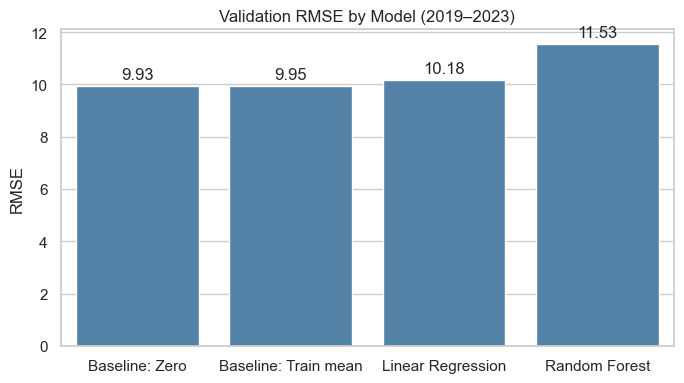

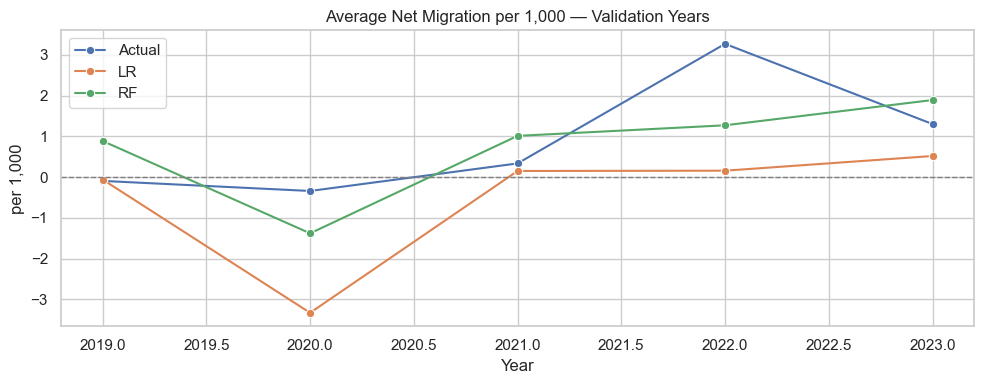

,RMSE,MAE,R2
Model,,,
Baseline: Zero,9.933752,4.652259,-0.008147
Baseline: Train mean,9.947684,4.651855,-0.010977
Linear Regression,10.177579,5.785225,-0.058245
Random Forest,11.527128,4.146500,-0.357499


In [6]:
# Evaluation

# Bar plot of RMSE (lower is better)
plt.figure(figsize=(7,4))
ax = sns.barplot(x=results_df.index, y=results_df["RMSE"], color="steelblue")
plt.title("Validation RMSE by Model (2019–2023)")
plt.ylabel("RMSE"); plt.xlabel("")
ax.bar_label(ax.containers[0], fmt="%.2f", padding=3)
plt.tight_layout(); plt.show()

# Predicted vs Actual (year-averaged)
valid_year_pred = (
    pd.DataFrame({
        "year": df_model.loc[valid_mask, "year"].values,
        "y_true": y_valid.values,
        "lr_pred": y_pred_lr,
        "rf_pred": y_pred_rf
    })
    .groupby("year", as_index=False).mean()
)

plt.figure(figsize=(10,4))
sns.lineplot(data=valid_year_pred, x="year", y="y_true", marker="o", label="Actual")
sns.lineplot(data=valid_year_pred, x="year", y="lr_pred", marker="o", label="LR")
sns.lineplot(data=valid_year_pred, x="year", y="rf_pred", marker="o", label="RF")
plt.title("Average Net Migration per 1,000 — Validation Years")
plt.ylabel("per 1,000"); plt.xlabel("Year")
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.tight_layout(); plt.show()

results_df


## 7. Feature Importance (RF, exploratory)

> RF may underperform overall, but its importances can still surface **non-linear drivers**.  
> We treat this as **exploratory** and do not overinterprete.


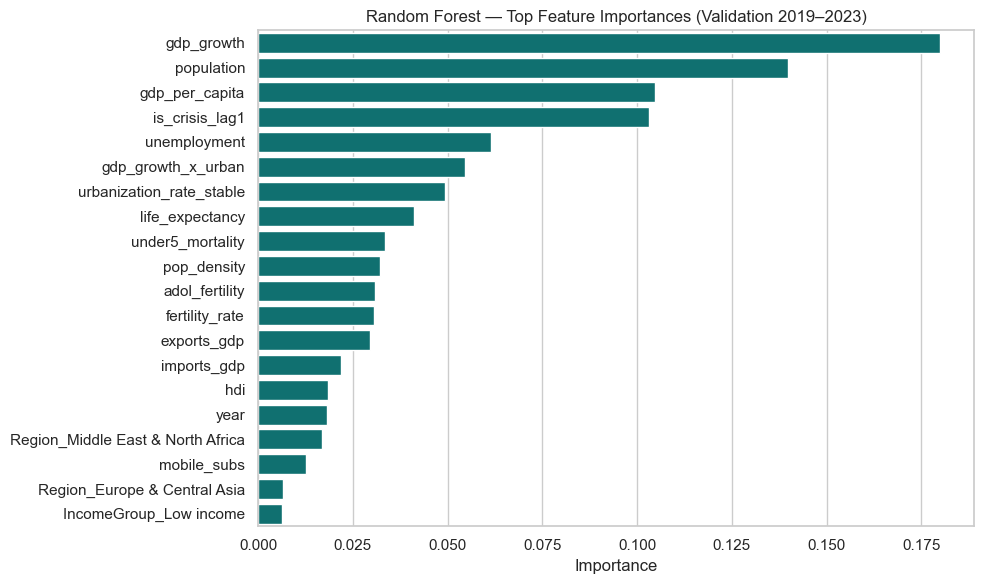

,importance
gdp_growth,0.179901
population,0.139901
gdp_per_capita,0.104724
is_crisis_lag1,0.103243
unemployment,0.061371
gdp_growth_x_urban,0.054602
urbanization_rate_stable,0.049374
life_expectancy,0.041023
under5_mortality,0.033338
pop_density,0.032115


In [7]:
# Feature Importance (RF)

rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_top = rf_importance.head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=imp_top.values, y=imp_top.index, color="teal")
plt.title("Random Forest — Top Feature Importances (Validation 2019–2023)")
plt.xlabel("Importance"); plt.ylabel("")
plt.tight_layout(); plt.show()

rf_importance.to_frame("importance").head(25)


## 8. Error Slices (by Region/Income)


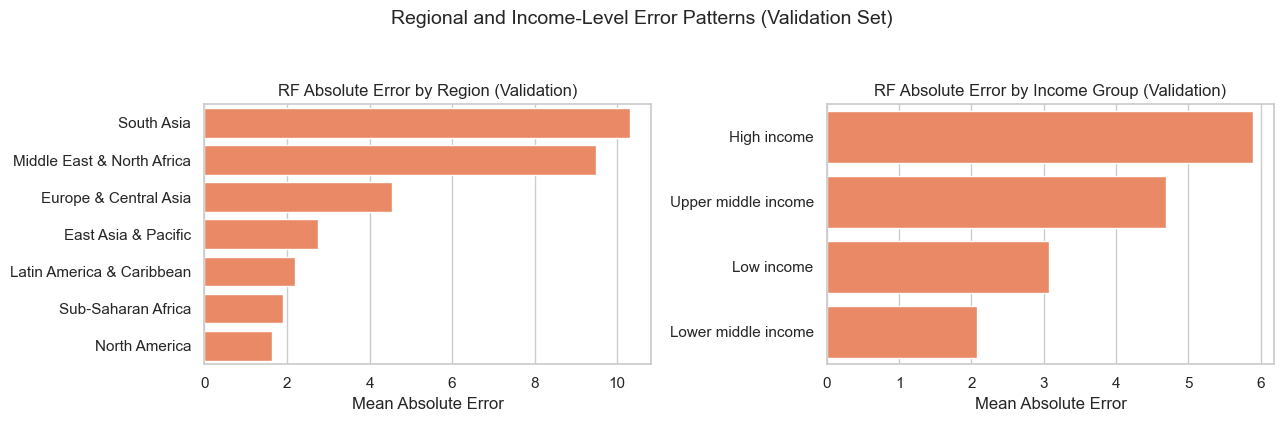

In [8]:
# --- 8) Error Slices (Barplots only) ---

# Prepare evaluation dataframe
valid_keys = df.loc[valid_mask, ["Country Name", "year", "Region", "IncomeGroup"]].reset_index(drop=True)
valid_eval = valid_keys.copy()
valid_eval["y_true"] = y_valid.values
valid_eval["rf_pred"] = y_pred_rf
valid_eval["abs_err"] = (valid_eval["y_true"] - valid_eval["rf_pred"]).abs()

# --- Compute mean absolute error by region and income group ---
err_region = valid_eval.groupby("Region", dropna=False)["abs_err"].mean().sort_values(ascending=False)
err_income = valid_eval.groupby("IncomeGroup", dropna=False)["abs_err"].mean().sort_values(ascending=False)

# --- Plot barplots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.barplot(x=err_region.values, y=err_region.index, color="coral", ax=axes[0])
axes[0].set_title("RF Absolute Error by Region (Validation)", fontsize=12)
axes[0].set_xlabel("Mean Absolute Error")
axes[0].set_ylabel("")

sns.barplot(x=err_income.values, y=err_income.index, color="coral", ax=axes[1])
axes[1].set_title("RF Absolute Error by Income Group (Validation)", fontsize=12)
axes[1].set_xlabel("Mean Absolute Error")
axes[1].set_ylabel("")

plt.suptitle("Regional and Income-Level Error Patterns (Validation Set)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


## 9. Save Artifacts, model and feature lists

In [9]:
## Save Artifacts, Model, and Feature Lists

# Output Directory
OUT_DIR = Path("../models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save results and feature importances
results_df.to_csv(OUT_DIR / "03_results_summary.csv", index=True)
rf_importance.to_csv(OUT_DIR / "03_rf_feature_importance.csv", index=True)

print(f"Saved results to: {OUT_DIR / '03_results_summary.csv'}")
print(f"Saved feature importances to: {OUT_DIR / '03_rf_feature_importance.csv'}")

# Save trained model and feature list
joblib.dump(rf, OUT_DIR / "random_forest_model.pkl")
joblib.dump(X_cols, OUT_DIR / "X_columns.pkl")

print(f"Random Forest model saved to: {OUT_DIR / 'random_forest_model.pkl'}")
print(f"Feature list saved to: {OUT_DIR / 'X_columns.pkl'}")


Saved results to: ../models/03_results_summary.csv
Saved feature importances to: ../models/03_rf_feature_importance.csv
Random Forest model saved to: ../models/random_forest_model.pkl
Feature list saved to: ../models/X_columns.pkl


## 10. Next Steps

- Tune models (e.g., **Ridge/Lasso, Gradient Boosting, XGBoost/LightGBM**) with time-aware CV.  
- Add **lags** of key predictors (HDI, GDP per capita, unemployment) and **rolling averages**.  
- Consider **country fixed effects** (target de-meaning) or mixed models.  
- Experiment with **quantile loss** to handle skew/outliers.  
- Use **SHAP** on the best model to explain predictions.  
